In [1]:
#멀티라벨 분류
#음식라벨 4가지를 데이터셋으로 만들었음

from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

#caltech_dir: 에서 이미지와 라벨명을 가져옴
caltech_dir = "D:/food-5"

#D:/final" 폴더에 있는 하위폴더이름을 불러오기(->categories)
categories  = os.listdir(caltech_dir)
nb_classes = len(categories )
image_w = 128
image_h = 128
#pixels = image_h * image_w * 3

X = []
y = []

In [2]:
categories

['계란찜', '고사리나물', '삼계탕', '오징어채볶음', '콩자반']

In [3]:
for idx, cat in enumerate(categories):
    
#one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)

#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식

X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/food5-1.npy", xy)  #

print("ok", len(y))

계란찜  파일 길이 :  784
계란찜  :  D:/food-5/계란찜\Img_125_0000.jpg
계란찜  :  D:/food-5/계란찜\Img_125_0871.jpg
고사리나물  파일 길이 :  896
고사리나물  :  D:/food-5/고사리나물\Img_041_0000.JPG
고사리나물  :  D:/food-5/고사리나물\Img_041_0782.jpg
삼계탕  파일 길이 :  864
삼계탕  :  D:/food-5/삼계탕\Img_138_0000.jpg
삼계탕  :  D:/food-5/삼계탕\Img_138_0785.jpg
오징어채볶음  파일 길이 :  704
오징어채볶음  :  D:/food-5/오징어채볶음\Img_087_0003.jpg
오징어채볶음  :  D:/food-5/오징어채볶음\Img_087_1070.jpg
콩자반  파일 길이 :  675
콩자반  :  D:/food-5/콩자반\Img_025_0001.jpg
ok 3923


In [ ]:
위에는 4가지(숙주나물~~애호박볶음)데이터셋 만드는거 
아래는 food128.npy데이터셋 불러와서 내가 만든 모델에 넣고 돌리는거

In [9]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

nb_classes=5
X_train, X_test, y_train, y_test = np.load('./numpy_data/food5-1.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(2942, 128, 128, 3)
2942


In [10]:
#categories = ["airplanes", "buddha", "butterfly", "crab"] 우리 모델을 라벨이 4개인데 폴더별로 이미 이름이 있고,라벨로 쓸예정임
#nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [11]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/food5-1.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)            

In [13]:
#print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

In [14]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])


Train on 2942 samples, validate on 981 samples
Epoch 1/50
2942/2942 [==============================] - 10s 3ms/step - loss: 1.4190 - accuracy: 0.5354 - val_loss: 0.6065 - val_accuracy: 0.7543

Epoch 00001: val_loss improved from inf to 0.60650, saving model to ./model/food5-1.model
Epoch 2/50
2942/2942 [==============================] - 7s 2ms/step - loss: 0.5382 - accuracy: 0.7903 - val_loss: 0.4249 - val_accuracy: 0.8287

Epoch 00002: val_loss improved from 0.60650 to 0.42492, saving model to ./model/food5-1.model
Epoch 3/50
2942/2942 [==============================] - 7s 2ms/step - loss: 0.4825 - accuracy: 0.8141 - val_loss: 0.5217 - val_accuracy: 0.7625

Epoch 00003: val_loss did not improve from 0.42492
Epoch 4/50
2942/2942 [==============================] - 7s 2ms/step - loss: 0.4091 - accuracy: 0.8409 - val_loss: 0.3793 - val_accuracy: 0.8430

Epoch 00004: val_loss improved from 0.42492 to 0.37932, saving model to ./model/food5-1.model
Epoch 5/50
2942/2942 [====================

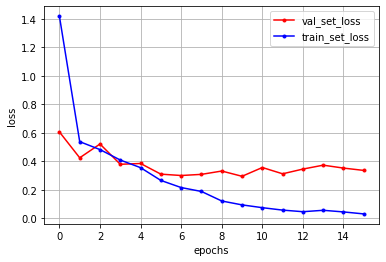

In [16]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [23]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "D:/final_test"
image_w = 128
image_h = 128

#pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    print(f)
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/food5-1.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = categories[pre_ans]
    print("해당 "+"이미지는 "+pre_ans_str+"로 추정됩니다.")


D:/final_test\계란찜.jpg
D:/final_test\고사리나물과.jpg
D:/final_test\삼계탕.jpg
D:/final_test\삼계탕2.jpg
D:/final_test\오징어채볶음.jpg
D:/final_test\오징어채볶음2.jpg
[1.000 0.000 0.000 0.000 0.000]
0
해당 이미지는 계란찜로 추정됩니다.
[0.000 0.000 1.000 0.000 0.000]
2
해당 이미지는 삼계탕로 추정됩니다.
[1.000 0.000 0.000 0.000 0.000]
0
해당 이미지는 계란찜로 추정됩니다.
[0.000 0.000 1.000 0.000 0.000]
2
해당 이미지는 삼계탕로 추정됩니다.
[0.000 0.000 0.000 1.000 0.000]
3
해당 이미지는 오징어채볶음로 추정됩니다.
[0.000 0.000 0.000 1.000 0.000]
3
해당 이미지는 오징어채볶음로 추정됩니다.


In [19]:
len(files)

2